In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Necessary HSC Data

- We are going to use `unagi` tool to access HSC data through the NAOJ public data release:
    - Please visit [HSC SSP website](https://hsc.mtk.nao.ac.jp/ssp/) for basic information of the survey
    - We will be using the [Public Data Release 2](https://hsc-release.mtk.nao.ac.jp/doc/). Please use this website for related publications and technical details.
    - You need to register an account to use the data. Please use the [form here](https://hsc-release.mtk.nao.ac.jp/datasearch/new_user/new)
    - **Important**: NAOJ will assign you a random and complex password. You _WON'T_ be able to change it to something you can easily remember. So write it down somewhere safe! The good people at NAOJ take cyber security really seriously.
    - Once you have the account, you can use the [online data access interface](https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/) to access data. Please feel free to explore.
    - Meanwhile, for easy access of data in `Python` and `Jupyter` notebook. We are going to use the `unagi` library.
    
### `unagi`

- [`unagi`](https://github.com/dr-guangtou/unagi) is a simple `Python` tool I created to search and download data from Hyper Suprime-Cam (HSC) Subaru Strategic Survey (SSP).
    - You should be able to install it using just `pip install unagi`. Please make sure you are using `Python 3`. 
    - You should also feel free to explore the code in the github repo.
    - I have prepared [some demo notebooks](https://github.com/dr-guangtou/unagi/tree/master/demo) to help you become familiar with both HSC data and `unagi`.
    - **Important**: I strongly recommend you go through a few demos in the following order:
        - [Basic of HSC database setup](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_config.ipynb)
        - [How to use HSC filters](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_filters.ipynb)
        - [Basics about HSC cutout generation](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_cutout.ipynb)
        - [Basics about HSC PSF model](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_psf.ipynb)
        - [Basics about the mask planes used by HSC](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_mask.ipynb)
        - [How to generate three-color pictures of HSC object](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_color_image.ipynb)
    - Once you have went through the above ones, you will have no problem understanding what's going on below.
    
### Credits:

- **Important**: If you find `unagi` or this demo useful. Please remember that 99.9% of the credit goes to the great HSC SSP team in Japan, Princeton, and ASIA for preparing the data; and to the wonderful people at NAOJ for creating these useful tools.
- If you are using HSC data or this demo for teaching/researching, please be sure to follow the appropriate rules for citation and acknowledgement.

In [16]:
from unagi import config
from unagi import hsc
from unagi import mask
from unagi import plotting
from unagi.task import hsc_cutout, hsc_psf

# Setup the HSC PDR2 data archive.
# If you want the Deep or Ultra-Deep data, please set the rerun to `pdr2_dud`.
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


### Galaxy sample

- The minimum information you need to generate cutouts (or post-stamps) is just a catalog with (RA, Dec) of the objects in them.
    - You can also indicate the size of the cutouts or the name of the objects (we will demonstrate later).
    - For cutout size, `unagi` allows bother **angular** and **physical** size. 
    
- Here we are going to use three random low surface brightness galaxies in HSC 
    - (provided by Jia-Xuan Li from PKU/Princeton).

In [7]:
#RA DEC
#243.88821 42.92376
#244.83857 42.25044
#236.74121 42.59723

ra = [243.88821, 244.83857, 236.74121]
dec = [42.92376, 42.25044, 42.59723]

sample = Table(
    [ra, dec], names=['ra', 'dec']
)

## Example for a single object

- Here we will generate cutouts in a single band: HSC $i$-band. 
    - In HSC, $i$-band typically has the best seeing. It is usually a good choice to study the structure of nearby galaxies.
- The cutout size will be 60 arcsec x 60 arcsec.
    - Unfortunately, I choose to use `cutout_size` as the keyword...It is more like the "half_size" or "radius" if you want...So be careful! 
        - **TODO**: My bad, I will fix it later (probably never...)
- We will keep the output data in a folder called `data` and in case we have downloaded the data in that folder, we will not do that again (by setting `use_saved=True`).
- We will get both the image and the variance ($\sigma^2$; for pixel-to-pixel uncertainty) and the mask planes that indicate the data quality and potential issues. We need the last two because they are necessary for image modeling...and because we are serious scientist.
- Here, we will provide a simple prefix, `dwarf_demo`, to name the downloaded files. They will be named as `dwarf_demo_1/2/3`
- And we are going to use the `plotting.display_all` function to check out the data.

# Read in saved FITS file: data/dwarf_demo_i.fits


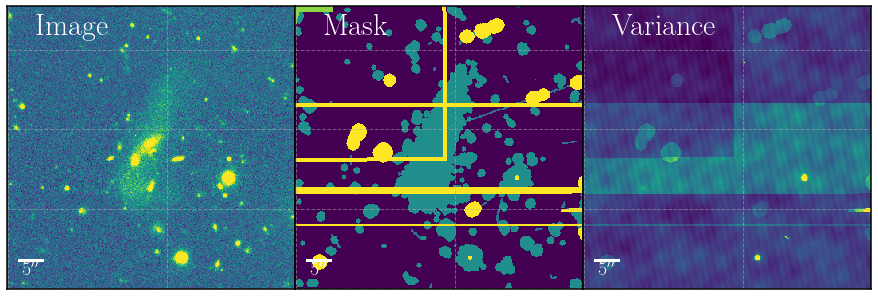

In [11]:
# Download an example mask plane
ra_obj, dec_obj = sample[0]['ra'], sample[0]['dec']
coord = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

# Size of the cutout should be large enough to contain all the fluxes of the galaxy
#    we want to study and also leave enough space to evaluate background level.
s_ang = 30 * u.arcsec

cutout = hsc_cutout(
    coord, cutout_size=s_ang, filters='i', archive=pdr2,
    use_saved=True, verbose=True, save_output=True, mask=True, variance=True, 
    prefix='dwarf_demo_1', output_dir='data')

label_list = [r"$\rm {}$".format(label) for label in ['Image', 'Mask', 'Variance']]
_ = plotting.display_all(
    cutout, hdu_list=True, img_size=4, label_list=label_list, 
    fontsize=30, fontcolor='w')

- Cutout image we downloaded has three HDUs. 
    - There is no Primary HDU.
    - HDU 1 is the image it self.
    - HDU 2 is the mask plane.
    - HDU 3 is the variance array.

In [13]:
i_img = cutout[1].data
i_msk = cutout[2].data
i_var = cutout[3].data

### Basics of HSC image and object detection

- Here we are going to briefly mention a few words about the image data. What's the unit? What's the "S/N" of these images.
     - The pixel value on the science image reflects the flux density measured at a given pixel. We call it "flux density" because we normalize the flux to the total (or effective) exposure time.
        - This is the science **signal** we rely on.
        - **Important**: so the image have effective exposure time of 1 second. This is important to know for modeling galaxies. For example, for tools like `galfit` or `imfit`, you need to provide the correct "sigma image" to use them.
    - The flux density value has been calibrated to system called the [AB magnitude system](https://en.wikipedia.org/wiki/AB_magnitude)
        - For a flux measurement at any given HSC band, you can convert the image pixel value into AB magnitude using a constant **zeropoint=27.0 mag**.
        - $m_{\rm AB} = -2.5 \log_{10}f_{\rm pixel} + 27.0$
        - The magnitude system does not really much sense outside astronomy, but it has been adopdate for weird reasons for more than a century...so it is very hard to change. Just keep reminding yourself that brigther object has higher flux, but has lower value in the magnitude system.
    - At the same time, the variance map provides measurements of the uncertainty of flux density measurement.
        - In some way, it measure the **noise** of the signal we want to detect. But also remember that this is not just the statistical "noise" or random uncertainties but also include **systematic uncertainties**.
        - Also remember that variance is square of the uncertainty value.
    - There is a lot to be said in the **detection** of astronomical object.
        - But, to the zeroth order, we basically apply a signal-to-noise (S/N) ratio cut to the image. e.g. We only think we actually detect something when S/N > 5. We can naively call this a "5-sigma" detection.
        - This will give us all the pixels with flux density value above certain significance level.

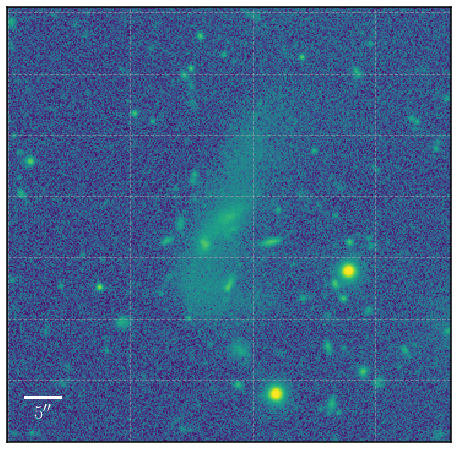

In [14]:
# Convert the variance map into uncertainty map (or `sigma` map).
i_sig = np.sqrt(i_var)

# Then we can get a simple S/N map
i_s2n = i_img / i_sig

# Although this looks very similar to the science image, the value distribution is different.
# This is what the object detection algorithm "sees". 
# Notice that this is very over-simplified: S/N can't be negative; 
#    but we are dealing with background subtracted image, so a lot of the pixels
#    have negative values. This doesn't mean the pixel has "negative" flux, but 
#    the pixel value is below the mean background level.

_ = plotting.display_single(i_s2n)

- **Question**: Do you think this "Signal-to-Noise" map is accurate? If not, why?

### Mask plane

- Please see [this demo](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_mask.ipynb) to understand the meaning of each mask plane
- To model the galaxy on the image, we usually want to treat the following three planes as "bad pixels", though the bright star plane is optional depending on whether the bright star bothers your target.
    1. `SAT`: Saturated pixels
    2. `BAD`: Bad pixels
    3. `BRIGHT_OBJECT` regions that are affected by a bright star.
- In this demo, we are very lucky: there is no bad pixel; both saturation and bright stars do not bother us. 
- The `DETECTED` mask plane can also help us later: it means the `hscPipe` pipeline "thinks" these pixels belong to an object.

['SAT', 'INTRP', 'CR', 'DETECTED', 'BRIGHT_OBJECT', 'REJECTED', 'CLIPPED', 'SENSOR_EDGE', 'INEXACT_PSF']


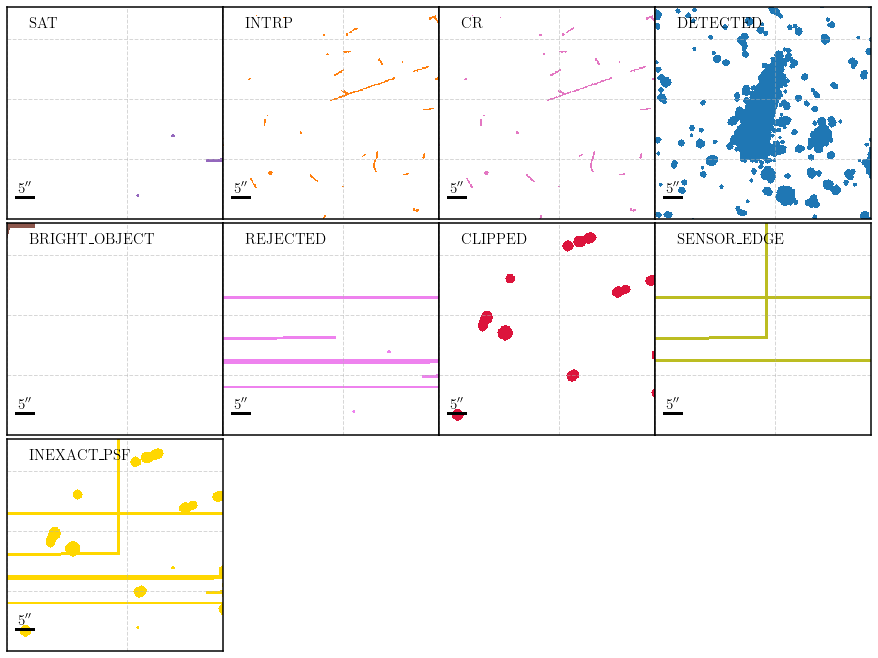

In [15]:
# We first convert the single mask plane into something that is easier to understand
mask_demo = mask.Mask(i_msk, data_release='pdr2')

# The following mask planes are occupied
print(mask_demo.name_used())

# Visualizing these mask planes can help you understand what's going on during the image reduction process.
# So we have a few saturated pixels which we will need to mask out (SAT & NO_DATA)
# CR stands for cosmic ray, these pixels have been interpolated over (INTRP)
# We don't have bright star mask on this image.
_, mm = mask_demo.show_used()

### PSF model

- We also want the PSF model at the center of the object so that we can use it when modeling the galaxy.
    - Please check [this demo](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_psf.ipynb) for more information.
    - And please read the [HSC SSP Pipeline](https://arxiv.org/abs/1705.06766) paper for details about the PSF modeling process. 
        - If you know the famous `PSFex` algorithm, it is pretty similar to what has been used for HSC.

# Retrieving coadd PSF model in filter: i


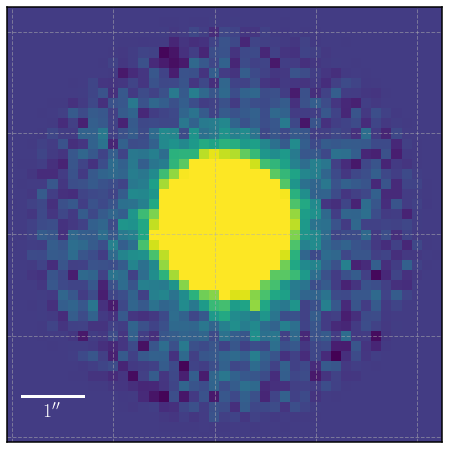

In [17]:
# Getting PSF image is rather simple...
# Get single band PSF image

psf_model = hsc_psf(coord, filters='i', archive=pdr2, output_dir='data/', prefix='dwarf_demo_1')

_ = plotting.display_single(psf_model[0].data, scale_bar_length=1.0)

- The PSF image looks pretty boring, which is GOOD!

## Batch download image and PSF 

- Just bundle the above procedures into a function, you are good to go.

- Let's update the table to show how to name your targets and generate cutouts of different sizes.

- And we will use `gri` to download data in three filters. You can do `grizy` for all five HSC band if you want.

In [21]:
# Name of the object
name = ['gal_a', 'gal_b', 'gal_c']

# Half-size of the cutout.
half_size = [20, 15, 30]  # in arcsec

# Sometime you can forget what's the unit your are using, arcsec? kpc? pixel? (not likely in our case...)
# You can use the astropy.units.Quantity and the "Quantity" table for it.
half_size *= u.Unit("arcsec")

# Make a QTable
sample = QTable(
    [name, ra, dec, half_size], names=['name', 'ra', 'dec', 'radius']
)

In [32]:
def download_cutout(
    obj, archive, filters='i', use_saved=True, ra='ra', dec='dec', name='name', 
    radius='radius', output_dir='data', verbose=False):
    """Download cutout image and the PSF for a single object."""

    coord = SkyCoord(obj[ra], obj[dec], frame='icrs', unit='deg')
    
    if name is not None:
        prefix = obj[name].strip()

    cutout = hsc_cutout(
        coord, cutout_size=obj[radius], filters=filters, archive=archive,
        use_saved=use_saved, verbose=verbose, save_output=True, 
        mask=True, variance=True, prefix=prefix, output_dir=output_dir)

    psf = hsc_psf(
        coord, filters=filters, archive=archive, output_dir=output_dir, 
        verbose=verbose, prefix=prefix)

    return cutout, psf

In [30]:
# Test it
_ = download_cutout(
    sample[0], pdr2, filters='gri', output_dir='data', verbose=True)

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving coadd PSF model in filter: g
# Retrieving coadd PSF model in filter: r
# Retrieving coadd PSF model in filter: i


In [31]:
# Batch download

_ = [download_cutout(obj, pdr2, filters='gri', output_dir='data', verbose=False) for obj in sample]

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving coadd PSF model in filter: g
# Retrieving coadd PSF model in filter: r
# Retrieving coadd PSF model in filter: i
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving coadd PSF model in filter: g
# Retrieving coadd PSF model in filter: r
# Retrieving coadd PSF model in filter: i
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving coadd PSF model in filter: g
# Retrieving coadd PSF model in filter: r
# Retrieving coadd PSF model in filter: i


**Important**: For a large sample, you may rightfully want to paralle the process to speed things up. It is still unclear to me how much you can speed things up...before NAOJ thinks you are abusing the API...I haven't stress tested it yet. So be mindful, and not try to submit 100 API calls at the same time.